### Use this markdown to generate the predictors


In [2]:
#imported libraries
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Creating of the input data
downloads = pd.read_csv('train_app_downloads.csv')
reviews = pd.read_csv('train_app_review.csv')
ratings = pd.read_csv('train_app_rating.csv')
usages = pd.read_csv('train_usage.csv')
revenues = pd.read_csv('train_revenue.csv')
output = pd.read_csv('train_final_downloads.csv')
dateRange = pd.date_range('2015-03-01', periods=56).format(formatter=lambda x: x.strftime('%Y-%m-%d'))

sentiment = pd.read_csv('sentiment.csv',header=-1).ix[:,0]
sentiment.values[sentiment.values==0.0] = 0.5
reviews["sentiment_score"] = sentiment.values 

#We map -1 to 0 in the downloads (there are no 0 in the initial data)
replacementValue=0
downloads = downloads.replace(-1,replacementValue)

#Minor corrections
ratings = ratings.rename(columns={'start1': 'star1'})
ratings = pd.merge(downloads.drop(dateRange,1), ratings.drop('Unnamed: 0', 1), how='left',
                   on=["id","name","category"]).replace("NaN",replacementValue)

#### Initialize the predictors matrix

In [3]:
predictors = pd.concat([downloads["id"],downloads["name"],downloads["category"],downloads["device"]],
                       axis=1,keys=["id","name","category","device"])
predictors.head()

,id,name,category,device
0,281704574,"AIM: Chat, Free Text, Photo Share, Voice Message",Social Networking,iphone
1,281922769,Mobile MIM,Medical,ipad
2,281922769,Mobile MIM,Medical,iphone
3,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,ipad
4,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,iphone


#### Use the train_app_downloads.csv file

In [4]:
#Generate the logWeekly average
def generator_weekAvg(inp,w):
    if (np.count_nonzero(inp[5+w*7:12+w*7] - replacementValue*np.ones(len(inp[5+w*7:12+w*7]))) == 0):
        return 0
    return  math.log(1.0*sum(inp[5+w*7:12+w*7])/np.count_nonzero(inp[5+w*7:12+w*7] 
                                                                 - replacementValue*np.ones(len(inp[5+w*7:12+w*7]))))

for w in range(8):
    predictors["week_"+str(w+1)] = downloads.apply(generator_weekAvg,axis=1,args=(w,))

In [5]:
#Generate the daily average
def generator_dailyAvg(inp):
    if (np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:]))) == 0):
        return 0
    return  (1.0*sum(inp[5:])/np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:]))))
    #return  math.log(1.0*sum(inp[5:])/len(inp[5:]))

predictors["daily_avg"] = downloads.apply(generator_dailyAvg,axis=1)
#This one is bad

In [6]:
#Generate the polynomial coefficients
def generator_coef(inp, coef):
    return  np.polyfit(range(56),inp[5:],coef)[0]
#Redo by ignoring the -1 / 0 ? w = [1110011]     w = np.not_equal(inp[5:],np.ones(len(inp[5:]))*replacementValue

for c in range(4):
    predictors["coef_"+str(c)] = downloads.apply(generator_coef,axis=1,args=(c,))

In [7]:
#Generate the step max and min (we ignore the values of 0)
def generator_maxStep(inp,maximum):
    if (np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:]))) == 0):
        return 0
    m = 0
    for d in range(1,56):
        if (inp[5+d]!=replacementValue and inp[4+d]!=replacementValue):
            c = (inp[5+d]-inp[4+d])
            if (maximum and m < c):
                m = c
            if ( not maximum and m > c):
                m = c
    return m
                
predictors["maxStep"] = downloads.apply(generator_maxStep,axis=1,args=(True,))
predictors["minStep"] = downloads.apply(generator_maxStep,axis=1,args=(False,))

In [8]:
#Standard Deviation
def generator_std(inp):
    if (np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:]))) == 0):
        return 0
    return np.std(inp[5:])

predictors["std"] = downloads.apply(generator_std,axis = 1)

In [9]:
#Number of missing Values
def generator_missing(inp):
    return list(inp[5:]).count(replacementValue)
    #return np.count_zero(inp[5:] -replacementValue*np.ones(len(inp[5:])))

predictors["nb_missing"] = downloads.apply(generator_missing,axis = 1)

In [10]:
#device
def generator_iphone(inp):
    if (inp[4] == "iphone"):
        return 1
    else:
        return 0

def generator_ipad(inp):
    if(inp[4] == "ipad"):
        return 1
    else:
        return 0
    
predictors["iphone"] = downloads.apply(generator_iphone,axis = 1)
predictors["ipad"] = downloads.apply(generator_ipad,axis = 1)

In [11]:
#Categories
def generator_categories(inp,cat):
    if (inp[3] == cat):
        return 1
    else:
        return 0
    

for cat in list(set(downloads["category"])):
    predictors[cat] = downloads.apply(generator_categories,axis = 1,args=(cat,))

#### Use the train_app_rating.csv file

In [12]:
avg_reviews = reviews.groupby('id').agg('mean')
avg_reviews['rating']
predictors['avg_review'] = predictors.join(avg_reviews['rating'],on='id')['rating'].replace("NaN",0)

In [13]:
avg_reviews = reviews.groupby('id').agg('var')
avg_reviews['rating']
predictors['var_review'] = predictors.join(avg_reviews['rating'],on='id')['rating'].replace("NaN",0)

In [14]:
#raw ratings
predictors = pd.merge(predictors, ratings.drop('Unnamed: 0', 1), how='left',
                   on=["id","name","category","device"]).replace("NaN",replacementValue)

#### Use the sentiment score

In [15]:
#Later we can compute the weighted average of sentiment scores based on reviewers.
#add positive and negative columns to indicate the app's popularity
print reviews.ix[id==predictors.id[0],:]["sentiment_score"]
print reviews.ix[id==predictors.id[1],:]["sentiment_score"]
avg_score = [0]*predictors.shape[0]
predictors["positive"] = [0]*predictors.shape[0]
predictors["negative"] = [0]*predictors.shape[0]
for i in range(predictors.shape[0]):
    avg_score[i] = reviews.ix[reviews["id"]==predictors.id[i],:]["sentiment_score"].mean()
    if avg_score[i]>0.55: 
        predictors["positive"].values[i] = 1
    elif avg_score[i]<0.45: predictors["negative"].values[i] = 1
#predictors["avg_sentiment_score"] = avg_score

 

0.208647319075
0.208647319075


#### Use coeficients of metrics 

In [16]:
for i in range(4):
    predictors["m"+str(i+1)+"_max"] = np.zeros(predictors.shape[0]) 
    predictors["m"+str(i+1)+"_min"] = np.zeros(predictors.shape[0])
    predictors["m"+str(i+1)+"_mean"] = np.zeros(predictors.shape[0])
    predictors["m"+str(i+1)+"_std"] = np.zeros(predictors.shape[0])
    for j in range(3):
        predictors["m"+str(i+1)+"_coef_"+str(j)] = np.zeros(predictors.shape[0])

for i in range(predictors.shape[0]):
    if predictors["id"].values[i] not in usages["id"].values: continue
    for j in range(4):
        tmp = usages.ix[usages["id"] == predictors["id"].values[i],:]
        time_series = np.array(tmp.ix[tmp["metric"] == j+1,6:14])[0]   
        if -1 in time_series: continue
        X = np.array(range(8))
        fit = np.polyfit(X,time_series,2)
        for k in range(3):
            predictors["m"+str(j+1)+"_coef_"+str(k)].values[i] = fit[2-k]


In [17]:
print predictors.columns

Index([u'id', u'name', u'category', u'device', u'week_1', u'week_2', u'week_3',
       u'week_4', u'week_5', u'week_6', u'week_7', u'week_8', u'daily_avg',
       u'coef_0', u'coef_1', u'coef_2', u'coef_3', u'maxStep', u'minStep',
       u'std', u'nb_missing', u'iphone', u'ipad', u'Productivity',
       u'Entertainment', u'Travel', u'Sports', u'Music', u'Shopping',
       u'Finance', u'Business', u'Navigation', u'Food and Drink', u'Utilities',
       u'Newsstand', u'Health and Fitness', u'News', u'Lifestyle', u'Medical',
       u'Weather', u'Games', u'Catalogs', u'Social Networking',
       u'Photo and Video', u'Reference', u'Books', u'Education', u'avg_review',
       u'var_review', u'star1', u'star2', u'star3', u'star4', u'star5',
       u'positive', u'negative', u'm1_max', u'm1_min', u'm1_mean', u'm1_std',
       u'm1_coef_0', u'm1_coef_1', u'm1_coef_2', u'm2_max', u'm2_min',
       u'm2_mean', u'm2_std', u'm2_coef_0', u'm2_coef_1', u'm2_coef_2',
       u'm3_max', u'm3_min', u'm3_me

#### Use coeficients of revenue

In [18]:
for j in range(3):
    predictors["rev_coef_"+str(j)] = np.zeros(predictors.shape[0])
    predictors["rev_max"] = np.zeros(predictors.shape[0])
    predictors["rev_min"] = np.zeros(predictors.shape[0])
    predictors["rev_mean"] = np.zeros(predictors.shape[0])
    predictors["rev_std"] = np.zeros(predictors.shape[0])
for i in range(predictors.shape[0]):
    
    if predictors["id"].values[i] in revenues["id"].values: 
        curr_rev  = revenues.ix[revenues["id"]== predictors["id"].values[i],:]
        if predictors["device"].values[i] in curr_rev["device"].values:
            curr_rev = curr_rev.ix[curr_rev["device"] == predictors["device"].values[i],:]
            time_series = np.array(curr_rev.ix[:,5:61])[0]
            if -1 in time_series: continue 
            X = np.array(range(56))
            fit = np.polyfit(X,time_series,2)
            for k in range(3):  predictors["rev_coef_"+str(k)].values[i] = fit[2-k]            

## To csv



In [19]:
predictors.to_csv("predictors.csv")

In [20]:
predictors = pd.read_csv('predictors.csv').drop('Unnamed: 0', 1)

In [21]:
predictors.columns

Index([u'id', u'name', u'category', u'device', u'week_1', u'week_2', u'week_3',
       u'week_4', u'week_5', u'week_6', u'week_7', u'week_8', u'daily_avg',
       u'coef_0', u'coef_1', u'coef_2', u'coef_3', u'maxStep', u'minStep',
       u'std', u'nb_missing', u'iphone', u'ipad', u'Productivity',
       u'Entertainment', u'Travel', u'Sports', u'Music', u'Shopping',
       u'Finance', u'Business', u'Navigation', u'Food and Drink', u'Utilities',
       u'Newsstand', u'Health and Fitness', u'News', u'Lifestyle', u'Medical',
       u'Weather', u'Games', u'Catalogs', u'Social Networking',
       u'Photo and Video', u'Reference', u'Books', u'Education', u'avg_review',
       u'var_review', u'star1', u'star2', u'star3', u'star4', u'star5',
       u'positive', u'negative', u'm1_max', u'm1_min', u'm1_mean', u'm1_std',
       u'm1_coef_0', u'm1_coef_1', u'm1_coef_2', u'm2_max', u'm2_min',
       u'm2_mean', u'm2_std', u'm2_coef_0', u'm2_coef_1', u'm2_coef_2',
       u'm3_max', u'm3_min', u'm3_me

## How good did the predictor perform   --> Start running from here

In [34]:
#imported libraries
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Creating of the input data
downloads = pd.read_csv('train_app_downloads.csv')
reviews = pd.read_csv('train_app_review.csv')
ratings = pd.read_csv('train_app_rating.csv')
usages = pd.read_csv('train_usage.csv')
revenues = pd.read_csv('train_revenue.csv')
output = pd.read_csv('train_final_downloads.csv')
dateRange = pd.date_range('2015-03-01', periods=56).format(formatter=lambda x: x.strftime('%Y-%m-%d'))

sentiment = pd.read_csv('sentiment.csv',header=-1).ix[:,0]
sentiment.values[sentiment.values==0.0] = 0.5
reviews["sentiment_score"] = sentiment.values 

#We map -1 to 0 in the downloads (there are no 0 in the initial data)
replacementValue=0
downloads = downloads.replace(-1,replacementValue)

#Minor corrections
ratings = ratings.rename(columns={'start1': 'star1'})
ratings = pd.merge(downloads.drop(dateRange,1), ratings.drop('Unnamed: 0', 1), how='left',
                   on=["id","name","category"]).replace("NaN",replacementValue)

In [35]:
#This is the metric we use to determine our performance
def metric(y_pred,y_test,percent=1):
    top = int(len(y_pred)/100*percent)
    return (len(set([i[0] for i in sorted(enumerate(y_pred), key=lambda x:x[1],reverse=True)][0:top])
       .intersection([i[0] for i in sorted(enumerate(y_test), key=lambda x:x[1],reverse=True)][0:top])
               ))/(percent/100.0)/len(y_pred)*100

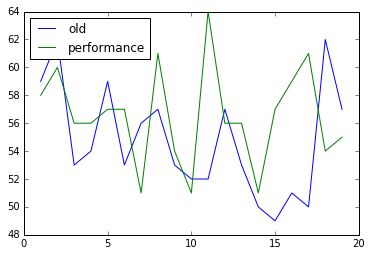

54.6842105263
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Travel', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Food and Drink', 'Utilities', 'Newsstand', 'Health and Fitness', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Books', 'Education', 'avg_review', 'var_review', 'star1', 'star2', 'star3', 'star4', 'star5', 'positive', 'negative', 'm1_max', 'm1_min', 'm1_mean', 'm1_std', 'm1_coef_0', 'm1_coef_1', 'm1_coef_2', 'm2_max', 'm2_min', 'm2_mean', 'm2_std', 'm2_coef_0', 'm2_coef_1', 'm2_coef_2', 'm3_max', 'm3_min', 'm3_mean', 'm3_std', 'm3_coef_0', 'm3_coef_1', 'm3_coef_2', 'm4_max', 'm4_min', 'm4_mean', 'm4_std', 'm4_coef_0', 'm4_coef_1', 'm4_coef_2', 'rev_max', 'rev_min', 

In [36]:
predictors = pd.read_csv('predictors.csv').drop('Unnamed: 0', 1)
predictors = predictors.fillna(0)

#Standardize
#for p in [ 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'ratingsWeightSum', 'star1', 'star2', 'star3', 'star4', 'star5']:
#    predictors[p] = (predictors[p] - predictors[p].mean())/predictors[p].std() 

#drop daily
#predictors = predictors.drop("week1",1)
#predictors = predictors.drop("week2",1)
#predictors = predictors.drop("week3",1)
#predictors = predictors.drop("week4",1)
#predictors = predictors.drop("week5",1)
#predictors = predictors.drop("week6",1)
#predictors = predictors.drop("week7",1)
#predictors = predictors.drop("week8",1)
# predictors = predictors.drop("daily_avg",1)
# predictors = predictors.drop("star1",1)
# predictors = predictors.drop("star2",1)
# predictors = predictors.drop("star3",1)
# predictors = predictors.drop("star4",1)
# predictors = predictors.drop("star5",1)
# predictors = predictors.drop(list(set(downloads["category"])),1)
# predictors = predictors.drop("coef_0",1)
# predictors = predictors.drop("coef_1",1)
# predictors = predictors.drop("coef_2",1)
# predictors = predictors.drop("coef_3",1)
# predictors = predictors.drop("maxStep",1)
# predictors = predictors.drop("minStep",1)
# predictors = predictors.drop("std",1)
# predictors = predictors.drop("nb_missing",1)
#predictors = predictors.drop("iphone",1)
# predictors = predictors.drop("ipad",1)

# predictors = predictors.drop('avg_sentiment_score',1)
# predictors = predictors.drop('positive',1)
# predictors = predictors.drop('negative',1)
# predictors = predictors.drop('m1_coef_0',1)
# predictors = predictors.drop('m1_coef_1',1)
# predictors = predictors.drop('m1_coef_2',1)
# predictors = predictors.drop('m2_coef_0',1)
# predictors = predictors.drop('m2_coef_1',1)
# predictors = predictors.drop('m2_coef_2',1)
# predictors = predictors.drop('m3_coef_0',1)
# predictors = predictors.drop('m3_coef_1',1)
# predictors = predictors.drop('m3_coef_2',1)
# predictors = predictors.drop('m4_coef_0',1)
# predictors = predictors.drop('m4_coef_1',1)
# predictors = predictors.drop('m4_coef_2',1)
predictors = predictors.drop('rev_coef_0',1)
predictors = predictors.drop('rev_coef_1',1)
predictors = predictors.drop('rev_coef_2',1)


old_top = []
new_top = []

test_frac = 0.31  #Fraction of test points
N = 20   #number of iterations
np.random.seed(1)
for i in range(1,N):
    r = np.random.randint(1,429496729)
    X_train, X_test, y_train, y_test = train_test_split(predictors.as_matrix()[:,4:12], output.as_matrix()[:,5], test_size=test_frac, random_state=r)
    X_test = X_test[0:10000]
    y_test = y_test[0:10000]
    old_mod=linear_model.LinearRegression(fit_intercept=False).fit(X_train,y_train)
    old_y_pred =  old_mod.predict(X_test)
    old_top.append(metric(old_y_pred,y_test))
    
np.random.seed(1)
for i in range(1,N):
    r = np.random.randint(1,429496729)
    X_train, X_test, y_train, y_test = train_test_split(predictors.as_matrix()[:,4:], output.as_matrix()[:,5], test_size=test_frac, random_state=r)
    X_test = X_test[0:10000]
    y_test = y_test[0:10000]
    #mod=linear_model.LinearRegression(fit_intercept=False).fit(X_train,y_train)
    mod=linear_model.Lasso(alpha=100,fit_intercept=False).fit(X_train,y_train)
    #mod= RandomForestRegressor(max_features = 1.0/3.0,n_estimators = 100) 
    y_pred =  mod.predict(X_test)
    new_top.append(metric(y_pred,y_test))
if (N<300):
    fig = plt.figure()
    plt.plot(range(1,N),old_top,label="old")
    plt.plot(range(1,N),new_top,label="performance")
    plt.legend(loc='best')
    plt.show()

print 1.0*sum(old_top)/len(old_top)
print list(predictors.columns.values)
print 1.0*sum(new_top)/len(new_top)

54.8947368421  
55.0526315789  #with #missing and Lasso <br/>
54.7894736842  #including raw ratings Lasso :( <br/>
55.0526315789  #with #missing weightedSumRatings and Lasso <br/>
55.1052631579  #adding the categories <br/>
55.3684210526  #adding average sentiment score and positive/negative label <br/>
55.5263157895  #adding coeficients of usages


With 10000 only:
54.8947368421 all

56.5263157895 on Lasso all but 'rev_coef_i'

Lasso All alpha = 100
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Travel', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Food and Drink', 'Utilities', 'Newsstand', 'Health and Fitness', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Books', 'Education', 'avg_review', 'var_review', 'star1', 'star2', 'star3', 'star4', 'star5', 'positive', 'negative', 'm1_coef_0', 'm1_coef_1', 'm1_coef_2', 'm2_coef_0', 'm2_coef_1', 'm2_coef_2', 'm3_coef_0', 'm3_coef_1', 'm3_coef_2', 'm4_coef_0', 'm4_coef_1', 'm4_coef_2']
57.1052631579

In [ ]:
#Estimation of alpha for the Lasso regression "cros validation" like approach

for a in np.arange(90,110,5):

    old_top = []
    new_top = []

    test_frac = 0.31  #Fraction of test points
    N = 20   #number of iterations


    np.random.seed(1)
    for i in range(1,N):
        r = np.random.randint(1,429496729)
        X_train, X_test, y_train, y_test = train_test_split(predictors.as_matrix()[:,4:], output.as_matrix()[:,5], test_size=test_frac, random_state=r)
        X_test = X_test[0:10000]
        y_test = y_test[0:10000]
        mod=linear_model.Lasso(alpha=a,fit_intercept=False).fit(X_train,y_train) 
        y_pred =  mod.predict(X_test)
        new_top.append(metric(y_pred,y_test))


    print a
    print 1.0*sum(new_top)/len(new_top)
    print " "

## Cross Validation k-folds

In [ ]:
K = 32

from sklearn.cross_validation import KFold

predictors = pd.read_csv('predictors.csv').drop('Unnamed: 0', 1)
predictors = predictors.fillna(0)

#Standardize
#for p in [ 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'ratingsWeightSum', 'star1', 'star2', 'star3', 'star4', 'star5']:
#    predictors[p] = (predictors[p] - predictors[p].mean())/predictors[p].std() 

#drop daily
#predictors = predictors.drop("week1",1)
#predictors = predictors.drop("week2",1)
#predictors = predictors.drop("week3",1)
#predictors = predictors.drop("week4",1)
#predictors = predictors.drop("week5",1)
#predictors = predictors.drop("week6",1)
#predictors = predictors.drop("week7",1)
#predictors = predictors.drop("week8",1)
# predictors = predictors.drop("daily_avg",1)
# predictors = predictors.drop("star1",1)
# predictors = predictors.drop("star2",1)
# predictors = predictors.drop("star3",1)
# predictors = predictors.drop("star4",1)
# predictors = predictors.drop("star5",1)
# predictors = predictors.drop(list(set(downloads["category"])),1)
# predictors = predictors.drop("coef_0",1)
# predictors = predictors.drop("coef_1",1)
# predictors = predictors.drop("coef_2",1)
# predictors = predictors.drop("coef_3",1)
# predictors = predictors.drop("maxStep",1)
# predictors = predictors.drop("minStep",1)
# predictors = predictors.drop("std",1)
# predictors = predictors.drop("nb_missing",1)
#predictors = predictors.drop("iphone",1)
# predictors = predictors.drop("ipad",1)

# predictors = predictors.drop('avg_sentiment_score',1)
# predictors = predictors.drop('positive',1)
# predictors = predictors.drop('negative',1)
# predictors = predictors.drop('m1_coef_0',1)
# predictors = predictors.drop('m1_coef_1',1)
# predictors = predictors.drop('m1_coef_2',1)
# predictors = predictors.drop('m2_coef_0',1)
# predictors = predictors.drop('m2_coef_1',1)
# predictors = predictors.drop('m2_coef_2',1)
# predictors = predictors.drop('m3_coef_0',1)
# predictors = predictors.drop('m3_coef_1',1)
# predictors = predictors.drop('m3_coef_2',1)
# predictors = predictors.drop('m4_coef_0',1)
# predictors = predictors.drop('m4_coef_1',1)
# predictors = predictors.drop('m4_coef_2',1)
predictors = predictors.drop('rev_coef_0',1)
predictors = predictors.drop('rev_coef_1',1)
predictors = predictors.drop('rev_coef_2',1)

kf = KFold(32339, n_folds=K)
old_top = []
new_top = []
for train, test in kf:
    #base model
    old_mod=linear_model.LinearRegression(fit_intercept=False).fit(predictors.as_matrix()[train,4:12], output.as_matrix()[train,5])
    old_y_pred =  old_mod.predict(predictors.as_matrix()[test,4:12])
    old_top.append(metric(old_y_pred,output.as_matrix()[test,5]))
    #model
    #mod=linear_model.LinearRegression(fit_intercept=False).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5]) 
    mod=linear_model.Lasso(alpha=100,fit_intercept=False).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5]) 
    #mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=1, random_state=0, loss='ls').fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5]) 
    #mod= RandomForestRegressor(max_features = 1.0/3.0,n_estimators = 100).fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5])
    y_pred =  mod.predict(predictors.as_matrix()[test,4:])
    new_top.append(metric(y_pred,output.as_matrix()[test,5]))
print 1.0*sum(old_top)/len(old_top)
print list(predictors.columns.values)
print 1.0*sum(new_top)/len(new_top)

# Lasso all
53.4375
['id', 'name', 'category', 'device', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'daily_avg', 'coef_0', 'coef_1', 'coef_2', 'coef_3', 'maxStep', 'minStep', 'std', 'nb_missing', 'iphone', 'ipad', 'Productivity', 'Entertainment', 'Travel', 'Sports', 'Music', 'Shopping', 'Finance', 'Business', 'Navigation', 'Food and Drink', 'Utilities', 'Newsstand', 'Health and Fitness', 'News', 'Lifestyle', 'Medical', 'Weather', 'Games', 'Catalogs', 'Social Networking', 'Photo and Video', 'Reference', 'Books', 'Education', 'avg_review', 'var_review', 'star1', 'star2', 'star3', 'star4', 'star5', 'positive', 'negative', 'm1_coef_0', 'm1_coef_1', 'm1_coef_2', 'm2_coef_0', 'm2_coef_1', 'm2_coef_2', 'm3_coef_0', 'm3_coef_1', 'm3_coef_2', 'm4_coef_0', 'm4_coef_1', 'm4_coef_2']
54.0625

## Predictor selection

In [ ]:
from sklearn.feature_selection import RFE
#mod=linear_model.Lasso(alpha=100,fit_intercept=False)
mod=linear_model.LinearRegression(fit_intercept=False)
#mod= RandomForestRegressor(max_features = 1.0/3.0,n_estimators = 100) 
rfe = RFE(estimator=mod, n_features_to_select=1, step=1)
rfe.fit(predictors.as_matrix()[train,4:], output.as_matrix()[train,5])
ranking = rfe.ranking_

In [ ]:
for e in sorted(zip(predictors.columns[4:],ranking),key=lambda x: x[1]):
    print e

## Attempt at boosting

In [ ]:
#Boosting

from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

new_top = []

test_frac = 0.31  #Fraction of test points
N = 20   #number of iterations



np.random.seed(1)
for i in range(1,N):
    r = np.random.randint(1,429496729)
    X_train, X_test, y_train, y_test = train_test_split(predictors.as_matrix()[:,4:], output.as_matrix()[:,5], test_size=test_frac, random_state=r)
    X_test = X_test[0:10000]
    y_test = y_test[0:10000]
    #mod=linear_model.LinearRegression(fit_intercept=False).fit(X_train,y_train)
    #mod=linear_model.Lasso(alpha=a,fit_intercept=False).fit(X_train,y_train) 
    mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=1, random_state=0, loss='ls').fit(X_train,y_train)
    mod= RandomForestRegressor(max_features = 1.0/3.0,n_estimators = 100) 
    y_pred =  mod.predict(X_test)
    new_top.append(metric(y_pred,y_test))

print 1.0*sum(new_top)/len(new_top)
print " "


In [ ]:
output.sort_values(by= 'cumulative_downloads_2016-02',ascending = False)


In [ ]:
predictors.columns
